In [31]:
'''
This code is for standard and adversarial (FSGM) training and testing of CNNs
Models: MobileNetV2, ResNet18, EfficientNet-B0, DenseNet121, VGGNet19
'''

import torch 
from datasets import load_from_disk

DATA_PATH = "~/Datasets/cv_project/resized_oxford_pets_22"
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_WORKERS = 4
# FSGM perturbation size
EPSILON = 0.01

# Load datasets 

ds = load_from_disk(DATA_PATH) # Visualize at https://huggingface.co/datasets/visual-layer/oxford-iiit-pet-vl-enriched

In [32]:
print(ds["train"].column_names)

['image_id', 'image', 'label_cat_dog', 'label_breed', 'caption_enriched', 'label_bbox_enriched', 'issues']


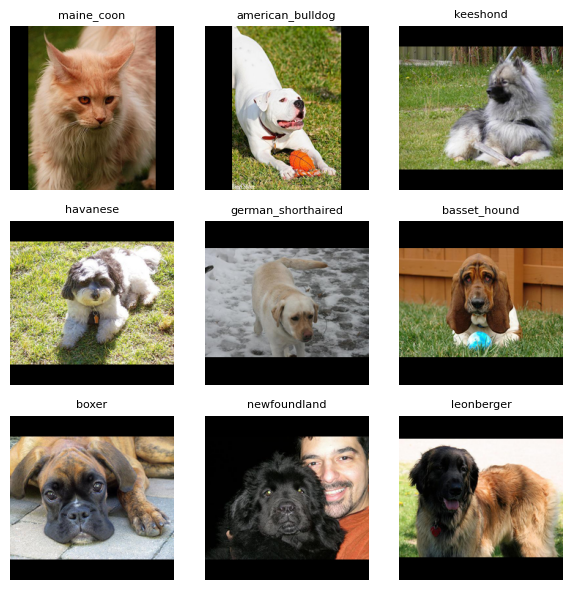

In [33]:
# Visualize samples
import matplotlib.pyplot as plt

def show_samples(split="train", n=9):
    data = ds[split]
    plt.figure(figsize=(6,6))
    for i in range(n):
        ex = data[i]
        img = ex["image"]           # PIL.Image
        lbl = ex["label_breed"]
        ax = plt.subplot(3, 3, i+1)
        ax.imshow(img)
        ax.set_title(str(lbl), fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize 9 samples from train and test
show_samples("train")


In [19]:
# Prepare data

from datasets import ClassLabel
from torch.utils.data import DataLoader
from torchvision import transforms 
import numpy as np

img_col   = 'image'
label_col = 'label_breed'

# Build a map from string labels to int
labels = ds['train'].unique(label_col)
labels.sort()                        
label2int = {v: i for i, v in enumerate(labels)}

print('Preparing data...')

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

print('Transforms defined!')
print('Applying transforms...')

# Apply transforms 
def preprocess(example):
    img = np.array(example[img_col], dtype=np.uint8)
    example['pixel_values'] = transform(img)
    example['labels'] = torch.tensor(label2int[example[label_col]], dtype=torch.long)
    return example

ds = ds.map(preprocess, remove_columns=[img_col, label_col])
ds.set_format(type='torch', columns=['pixel_values', 'labels'])

print('Pulling batches...')

# Pull batches
train_loader = DataLoader(ds['train'], batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
test_loader  = DataLoader(ds['test'],  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Ssanity check
print(f"train size: {len(ds['train'])}, test size: {len(ds['test'])}")
batch = next(iter(train_loader))
print(batch['pixel_values'].shape, batch['labels'].shape)


Preparing data...
Transforms defined!
Applying transforms...
Pulling batches...
train size: 3638, test size: 3626


torch.Size([32, 3, 224, 224]) torch.Size([32])


Preparing data...
Transforms defined!
Applying transforms...
Pulling batches...
train size: 3638, test size: 3626
torch.Size([32, 3, 224, 224]) torch.Size([32])


In [20]:
# Define device before loading models and optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Load Models 

from torchvision import models
from torch import nn
import timm

num_classes = len(label2int)

# MobileNetV2
mobilenet = models.mobilenet_v2(weights=True)
mobilenet.classifier[1] = nn.Linear(
    mobilenet.classifier[1].in_features, num_classes)
mobilenet = mobilenet.to(device)

# ResNet18 (standard fc)
resnet = models.resnet18(weights=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

# EfficientNet-B0
effnet = models.efficientnet_b0(weights=True)
in_feats = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(in_feats, num_classes)
effnet = effnet.to(device)

# DenseNet121
densenet = timm.create_model('densenet121', pretrained=True)
in_feats = densenet.classifier.in_features
densenet.classifier = nn.Linear(in_feats, num_classes)
densenet = densenet.to(device)

# VGGNet19 with GAP layer 
vggnet = timm.create_model('vgg19.tv_in1k',pretrained=True, num_classes=num_classes, global_pool='avg')
vggnet = vggnet.to(device)


/home/matildedolfato/venvs/cv_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/matildedolfato/venvs/cv_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/matildedolfato/venvs/cv_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weig

In [8]:
# Training Loop 

from torch import optim

def train_model(model, loader, epochs=NUM_EPOCHS):
    model.train()
    loss_f = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for batch in loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(inputs) # fw pass
            loss = loss_f(outputs, labels) 

            optimizer.zero_grad() # reset gradients from previous batch
            loss.backward() # bw pass
            optimizer.step() # update parameters
            total_loss += loss.item() * inputs.size(0)

        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")


In [9]:
# Train models

import gc

for name, model in [
    ("mobilenet", mobilenet), 
    ("resnet", resnet), 
    ("effnet", effnet),
    ("densenet", densenet),
    ("vggnet", vggnet)

]:
    print(f"Training {name}...")
    train_model(model, train_loader)
    torch.save(model.state_dict(), f"trained_models/{name}.pt")
    del model
    torch.cuda.empty_cache()
    gc.collect()

Training vggnet...
Epoch 1/10 - Loss: 1.0178
Epoch 2/10 - Loss: 0.3756
Epoch 3/10 - Loss: 0.2342
Epoch 4/10 - Loss: 0.1876
Epoch 5/10 - Loss: 0.1326
Epoch 6/10 - Loss: 0.0971
Epoch 7/10 - Loss: 0.0912
Epoch 8/10 - Loss: 0.1220
Epoch 9/10 - Loss: 0.1038
Epoch 10/10 - Loss: 0.0943


In [10]:
# Testing loop

# Define top-k accuracy
def top_k_accuracy(outputs, labels, k=5):
    _, topk_preds = outputs.topk(k, dim=1)
    correct = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct.any(dim=1).float().mean().item()

def test_model(model, loader, k=5):
    model.eval()
    correct1 = 0
    correct_k_total = 0.0
    total = 0
    with torch.no_grad():
        for batch in loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            # Get predictions
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            # Standard accuracy (top-1)
            correct1 += (preds == labels).sum().item()
            # Top-k
            batch_k_acc = top_k_accuracy(outputs, labels, k)
            correct_k_total += batch_k_acc * labels.size(0)
            total += labels.size(0)
    print(f"Top-1 Accuracy: {correct1/total:.4f}")
    print(f"Top-{k} Accuracy: {correct_k_total/total:.4f}")

In [13]:
# Test models

# Re-load models as before, with weights=False to avoid waste because I load my own weights later, by name
def get_model(name):
    if name == "mobilenet":
        model = models.mobilenet_v2(weights=False)
        model.classifier[1] = nn.Linear(
            model.classifier[1].in_features, num_classes)
    elif name == "resnet":
        model = models.resnet18(weights=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "effnet":
        model = models.efficientnet_b0(weights=False)
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)
    elif name =="densenet":
        model = timm.create_model('densenet121', pretrained=False)
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)
    elif name=="vggnet":
        model = timm.create_model('vgg19.tv_in1k',pretrained=True, num_classes=num_classes, global_pool='avg')
    else:
        raise ValueError(f"Unknown model: {name}")
    return model

for name in [
    "mobilenet", 
    "resnet", 
    "effnet",
    "densenet",
    "vggnet"
]:
    print(f"\nTesting adv. {name}...")

    # Save model to device
    model = get_model(name).to(device)
    # Load weights computed with training
    model.load_state_dict(torch.load(f"trained_models/{name}_adv.pt"))
    # Test
    model.eval()
    test_model(model, test_loader)

    # Cleanup memory between models
    del model
    torch.cuda.empty_cache()
    gc.collect()


Testing adv. densenet...


Top-1 Accuracy: 0.8530
Top-5 Accuracy: 0.9823

Testing adv. vggnet...
Top-1 Accuracy: 0.8136
Top-5 Accuracy: 0.9716


In [22]:
# Adversarial training loop (FSGM) 
# Reference: https://arxiv.org/pdf/1412.6572

import torch.optim as optim

# Normalization stats (same as in transforms)
means = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
stds  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

# Precompute the valid min/max for each channel in *normalized* space
min_val = (0.0 - means) / stds
max_val = (1.0 - means) / stds

def fgsm_attack(model, loss_f, x, y, epsilon):
    # Make a copy of x that we can take gradients wrt
    x_copy = x.clone().detach().requires_grad_(True)
    
    # Fw and Bw pass to compute graident of the loss wrt input x 
    outputs = model(x_copy) 
    loss = loss_f(outputs, y)
    model.zero_grad()
    loss.backward()
    
    # Perturbe x!
    sign_grad = x_copy.grad.sign()
    x_adv = x_copy + epsilon * sign_grad
    
    # if your inputs are normalized, you may want to clamp in normalized space
    # here we assume pixel range [0, 1]:
    x_adv = torch.max(torch.min(x_adv, max_val), min_val)
    
    return x_adv.detach()

# Train on adversarial examples 
def train_model_adv(model, loader, epochs=NUM_EPOCHS, epsilon=EPSILON):
    model.train()
    loss_f = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        for batch in loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
                        
            # Compute perturbed inputs!
            inputs_adv = fgsm_attack(model, loss_f, inputs, labels, epsilon)

            # Train half on perturbed half on clean (concretely averaging losses is the same as combining the dataset)
            outputs_clean = model(inputs)
            outputs_adv = model(inputs_adv)
            loss_clean = loss_f(outputs_clean, labels)
            loss_adv = loss_f(outputs_adv, labels)
            loss = 0.5 * loss_clean + 0.5 * loss_adv
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
        
        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {epoch}/{epochs} - Adv Loss: {avg_loss:.4f}")

In [ ]:
# Adversarially train models

import gc

for name, model in [
    ("mobilenet", mobilenet), 
    ("resnet", resnet), 
    ("effnet", effnet),
    ("densenet", densenet),
    ("vggnet", vggnet)
]:
    print(f"Adv. training {name}...")
    train_model_adv(model, train_loader)
    torch.save(model.state_dict(), f"trained_models/{name}_adv.pt")
    del model
    torch.cuda.empty_cache()
    gc.collect()

In [28]:
# Adversarial testing loop

# Define top-k accuracy
def top_k_accuracy(outputs, labels, k=5):
    _, topk_preds = outputs.topk(k, dim=1)
    correct = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct.any(dim=1).float().mean().item()

# Test models on adversarial examples
def adv_test_model(model, loader, k=5, loss_f=nn.CrossEntropyLoss(), epsilon=EPSILON):
    model.eval()
    correct1 = 0
    correct_k_total = 0.0
    total = 0
    for batch in loader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        # Create adversarial inputs
        inputs_adv = fgsm_attack(model, loss_f, inputs, labels, epsilon)
        with torch.no_grad():
            outputs = model(inputs_adv)
        # Top-1
        preds = outputs.argmax(dim=1)
        correct1 += (preds == labels).sum().item()
        # Top-k
        batch_k_acc = top_k_accuracy(outputs, labels, k)
        correct_k_total += batch_k_acc * labels.size(0)
        total += labels.size(0)
    print(f"Top-1 Accuracy: {correct1 / total:.4f}")
    print(f"Top-{k} Accuracy: {correct_k_total / total:.4f}")

In [35]:
# Adversarially test models

# Re-load models as before, with weights=False to avoid waste because I load my own weights later, by name
def get_model(name):
    if name == "mobilenet":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(
            model.classifier[1].in_features, num_classes)
    elif name == "resnet":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "effnet":
        model = models.efficientnet_b0(weights=None)
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)
    elif name =="densenet":
        model = timm.create_model('densenet121', pretrained=False)
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)
    elif name=="vggnet":
        model = timm.create_model('vgg19.tv_in1k',pretrained=True, num_classes=num_classes, global_pool='avg')
    else:
        raise ValueError(f"Unknown model: {name}")
    return model

for name in [
    "mobilenet", 
    "resnet", 
    "effnet",
    "densenet",
    "vggnet",
]:
    print(f"\nAdv. testing {name}_adv...")  # !! Replace {name}_adv with {name} to test standard models on perturbed data

    # Save model to device
    model = get_model(name).to(device)
    # Load weights computed with training
    model.load_state_dict(torch.load(f"trained_models/{name}_adv.pt")) # !! Replace {name}_adv with {name} to test standard models on perturbed data
    # Test
    model.eval()
    adv_test_model(model, test_loader)

    # Cleanup memory between models
    del model
    torch.cuda.empty_cache()
    gc.collect()


Adv. testing mobilenet...


Top-1 Accuracy: 0.1437
Top-5 Accuracy: 0.6277

Adv. testing resnet...
Top-1 Accuracy: 0.2785
Top-5 Accuracy: 0.7521

Adv. testing effnet...
Top-1 Accuracy: 0.2093
Top-5 Accuracy: 0.7237

Adv. testing densenet...
Top-1 Accuracy: 0.4184
Top-5 Accuracy: 0.8668

Adv. testing vggnet...
Top-1 Accuracy: 0.3315
Top-5 Accuracy: 0.8483
